In [1]:
import numpy as np, os
import matplotlib as mpl
%matplotlib notebook

In [2]:
workdir = '_tmp.explore-random-sampling-less-samples'
!mkdir -p {workdir}
%cd {workdir}

/home/lj7/dv/mcvine/phonon/tests/phonon/_tmp.explore-random-sampling-less-samples


In [3]:
from mcvine.phonon.from_phonopy import call_phonopy

In [4]:
supercell = 6,6,1
sc_mat = np.diag(supercell)

In [5]:
graphite_datadir = os.path.abspath('../../data/graphite/')

In [6]:
from phonopy import file_IO
force_constants=file_IO.parse_FORCE_CONSTANTS(os.path.join(graphite_datadir, 'FORCE_CONSTANTS'))

In [7]:
poscar = os.path.join(graphite_datadir, 'POSCAR')

In [8]:
species = ['C']

In [9]:
qpoints = [[0.,0.,0.]]

In [10]:
qs, freqs, pols = call_phonopy.onGrid(
    species, qpoints, sc_mat, 
    force_constants = force_constants,
    poscar = poscar)

# random

In [11]:
N = 10000
qpoints = np.random.rand(N, 3)

In [12]:
qs, freqs, pols = call_phonopy.onGrid(
    ['C'], qpoints, sc_mat, 
    force_constants = force_constants,
    poscar = os.path.join(graphite_datadir, 'POSCAR'),
    freq2omega=1
)

In [13]:
freqs[freqs<0] = 0

In [14]:
# omega2 = freqs**2 * 1e24 * (2*np.pi)**2

In [15]:
omega = freqs*1e12*2*np.pi

In [16]:
nq, nbr, natoms, three = pols.shape

In [17]:
assert three is 3

In [18]:
from phonopy.interface import vasp
atoms = vasp.read_vasp(poscar, species)
positions = atoms.get_scaled_positions()

In [19]:
for iatom in range(natoms):
    qdotr = np.dot(qs, positions[iatom]) * 2 * np.pi
    phase = np.exp(-1j * qdotr)
    pols[:, :, iatom, :] *= phase[:, np.newaxis, np.newaxis]
    continue

# Compute

In [20]:
from mcvine.phonon import from_phonopy

In [21]:
from_phonopy.make_crystal_xyz('graphite.xyz', species, poscar)

In [22]:
from sampleassembly.crystal.ioutils import xyzfile2unitcell

In [23]:
uc = xyzfile2unitcell('graphite.xyz')

In [24]:
Q_basis = uc.lattice.recbase * 2 * np.pi

In [25]:
# compute max Q for the first reciprocal unit cell                                                                                                                                                                                                                                                              
max_Q_1uc = np.max(np.linalg.norm(np.dot(qs, Q_basis), axis=-1))

In [26]:
from mccomponents.sample.idf import units

In [27]:
omega *= units.hertz2mev

In [28]:
omega[0]

array([  44.80386199,   45.21918758,   79.17351713,   79.18465028,
         87.97339073,   88.09162861,  142.67267818,  142.79055377,
        179.14777114,  179.17061452,  185.48391386,  185.55946013])

In [29]:
omega.shape

(10000, 12)

In [30]:
pols.shape

(10000, 12, 4, 3)

In [31]:
nbranches = 12

In [32]:
max_hkl = 25

In [33]:
# tau array                                                                                                                                                                                                                                                                                                     
tau1 = np.mgrid[-max_hkl:max_hkl+1, -max_hkl:max_hkl+1, -max_hkl:max_hkl+1]
tau1 = tau1.copy()
tau1.shape = 3, -1
tau1 = tau1.T

In [34]:
Q_bins = np.arange(0, 22, 0.1)
E_bins = np.arange(0, 250, 1.)
bins = Q_bins, E_bins
# max Q of requested Q axis                                                                                                                                                                                                                                                                                     
max_Q = Q_bins[-1]

In [35]:
%%time
I = 0
for tau_hkl in tau1:
    tau_hkl = np.array(tau_hkl)
    # print tau_hkl,   
    # no need to include this tau point if it is too far away from origin   
    Qtau_cart = np.dot(tau_hkl, Q_basis)
    Qtau_mag = np.linalg.norm(Qtau_cart)
    if Qtau_mag - max_Q_1uc > max_Q:
        # print "skipped"            
        continue
    else:
        print tau_hkl
    for ibr in range(nbranches):
        Q_hkl = tau_hkl + qs
        Q_cart = np.dot(Q_hkl, Q_basis)  # nQ, 3   
        Q_mag = np.linalg.norm(Q_cart, axis=-1) # nQ
        good = Q_mag < max_Q
        # 
        omega0 = omega[good, ibr]
        Q_cart = Q_cart[good]
        #
        exp_Q_dot_d = np.exp(1j * np.dot(Q_cart, positions.T)) # nQ, natoms 
        pols1 = pols[good, ibr, :, :] # nQ, natoms, 3   
        Q_dot_pol = np.sum(np.transpose(pols1, (1,0,2)) * Q_cart, axis=-1).T # nQ, natoms
        # 
        F = np.sum(exp_Q_dot_d * Q_dot_pol, axis=-1) # nQ      
        M = np.abs(F)**2 # nQ       
        I1, Qbb, Ebb = np.histogram2d(Q_mag[good], omega0, bins=bins, weights=M)
        I = I + I1
    continue

[-11   2  -7]
[-11   2  -6]
[-11   2  -5]
[-11   2  -4]
[-11   2  -3]
[-11   2  -2]
[-11   2  -1]
[-11   2   0]
[-11   2   1]
[-11   2   2]
[-11   2   3]
[-11   2   4]
[-11   2   5]
[-11   2   6]
[-11   2   7]
[-11   3  -9]
[-11   3  -8]
[-11   3  -7]
[-11   3  -6]
[-11   3  -5]
[-11   3  -4]
[-11   3  -3]
[-11   3  -2]
[-11   3  -1]
[-11   3   0]
[-11   3   1]
[-11   3   2]
[-11   3   3]
[-11   3   4]
[-11   3   5]
[-11   3   6]
[-11   3   7]
[-11   3   8]
[-11   3   9]
[-11   4  -9]
[-11   4  -8]
[-11   4  -7]
[-11   4  -6]
[-11   4  -5]
[-11   4  -4]
[-11   4  -3]
[-11   4  -2]
[-11   4  -1]
[-11   4   0]
[-11   4   1]
[-11   4   2]
[-11   4   3]
[-11   4   4]
[-11   4   5]
[-11   4   6]
[-11   4   7]
[-11   4   8]
[-11   4   9]
[-11   5  -8]
[-11   5  -7]
[-11   5  -6]
[-11   5  -5]
[-11   5  -4]
[-11   5  -3]
[-11   5  -2]
[-11   5  -1]
[-11   5   0]
[-11   5   1]
[-11   5   2]
[-11   5   3]
[-11   5   4]
[-11   5   5]
[-11   5   6]
[-11   5   7]
[-11   5   8]
[-11   6  -6]
[-11  

[ -8   0 -13]
[ -8   0 -12]
[ -8   0 -11]
[ -8   0 -10]
[-8  0 -9]
[-8  0 -8]
[-8  0 -7]
[-8  0 -6]
[-8  0 -5]
[-8  0 -4]
[-8  0 -3]
[-8  0 -2]
[-8  0 -1]
[-8  0  0]
[-8  0  1]
[-8  0  2]
[-8  0  3]
[-8  0  4]
[-8  0  5]
[-8  0  6]
[-8  0  7]
[-8  0  8]
[-8  0  9]
[-8  0 10]
[-8  0 11]
[-8  0 12]
[-8  0 13]
[-8  0 14]
[-8  0 15]
[-8  0 16]
[-8  0 17]
[-8  0 18]
[ -8   1 -19]
[ -8   1 -18]
[ -8   1 -17]
[ -8   1 -16]
[ -8   1 -15]
[ -8   1 -14]
[ -8   1 -13]
[ -8   1 -12]
[ -8   1 -11]
[ -8   1 -10]
[-8  1 -9]
[-8  1 -8]
[-8  1 -7]
[-8  1 -6]
[-8  1 -5]
[-8  1 -4]
[-8  1 -3]
[-8  1 -2]
[-8  1 -1]
[-8  1  0]
[-8  1  1]
[-8  1  2]
[-8  1  3]
[-8  1  4]
[-8  1  5]
[-8  1  6]
[-8  1  7]
[-8  1  8]
[-8  1  9]
[-8  1 10]
[-8  1 11]
[-8  1 12]
[-8  1 13]
[-8  1 14]
[-8  1 15]
[-8  1 16]
[-8  1 17]
[-8  1 18]
[-8  1 19]
[ -8   2 -20]
[ -8   2 -19]
[ -8   2 -18]
[ -8   2 -17]
[ -8   2 -16]
[ -8   2 -15]
[ -8   2 -14]
[ -8   2 -13]
[ -8   2 -12]
[ -8   2 -11]
[ -8   2 -10]
[-8  2 -9]
[-8  2 -8]
[

[-7  6 -7]
[-7  6 -6]
[-7  6 -5]
[-7  6 -4]
[-7  6 -3]
[-7  6 -2]
[-7  6 -1]
[-7  6  0]
[-7  6  1]
[-7  6  2]
[-7  6  3]
[-7  6  4]
[-7  6  5]
[-7  6  6]
[-7  6  7]
[-7  6  8]
[-7  6  9]
[-7  6 10]
[-7  6 11]
[-7  6 12]
[-7  6 13]
[-7  6 14]
[-7  6 15]
[-7  6 16]
[-7  6 17]
[-7  6 18]
[-7  6 19]
[ -7   7 -16]
[ -7   7 -15]
[ -7   7 -14]
[ -7   7 -13]
[ -7   7 -12]
[ -7   7 -11]
[ -7   7 -10]
[-7  7 -9]
[-7  7 -8]
[-7  7 -7]
[-7  7 -6]
[-7  7 -5]
[-7  7 -4]
[-7  7 -3]
[-7  7 -2]
[-7  7 -1]
[-7  7  0]
[-7  7  1]
[-7  7  2]
[-7  7  3]
[-7  7  4]
[-7  7  5]
[-7  7  6]
[-7  7  7]
[-7  7  8]
[-7  7  9]
[-7  7 10]
[-7  7 11]
[-7  7 12]
[-7  7 13]
[-7  7 14]
[-7  7 15]
[-7  7 16]
[ -7   8 -11]
[ -7   8 -10]
[-7  8 -9]
[-7  8 -8]
[-7  8 -7]
[-7  8 -6]
[-7  8 -5]
[-7  8 -4]
[-7  8 -3]
[-7  8 -2]
[-7  8 -1]
[-7  8  0]
[-7  8  1]
[-7  8  2]
[-7  8  3]
[-7  8  4]
[-7  8  5]
[-7  8  6]
[-7  8  7]
[-7  8  8]
[-7  8  9]
[-7  8 10]
[-7  8 11]
[ -6  -4 -12]
[ -6  -4 -11]
[ -6  -4 -10]
[-6 -4 -9]
[-6 -4 

[-5 -3 12]
[-5 -3 13]
[-5 -3 14]
[-5 -3 15]
[-5 -3 16]
[-5 -3 17]
[-5 -3 18]
[-5 -3 19]
[ -5  -2 -22]
[ -5  -2 -21]
[ -5  -2 -20]
[ -5  -2 -19]
[ -5  -2 -18]
[ -5  -2 -17]
[ -5  -2 -16]
[ -5  -2 -15]
[ -5  -2 -14]
[ -5  -2 -13]
[ -5  -2 -12]
[ -5  -2 -11]
[ -5  -2 -10]
[-5 -2 -9]
[-5 -2 -8]
[-5 -2 -7]
[-5 -2 -6]
[-5 -2 -5]
[-5 -2 -4]
[-5 -2 -3]
[-5 -2 -2]
[-5 -2 -1]
[-5 -2  0]
[-5 -2  1]
[-5 -2  2]
[-5 -2  3]
[-5 -2  4]
[-5 -2  5]
[-5 -2  6]
[-5 -2  7]
[-5 -2  8]
[-5 -2  9]
[-5 -2 10]
[-5 -2 11]
[-5 -2 12]
[-5 -2 13]
[-5 -2 14]
[-5 -2 15]
[-5 -2 16]
[-5 -2 17]
[-5 -2 18]
[-5 -2 19]
[-5 -2 20]
[-5 -2 21]
[-5 -2 22]
[ -5  -1 -23]
[ -5  -1 -22]
[ -5  -1 -21]
[ -5  -1 -20]
[ -5  -1 -19]
[ -5  -1 -18]
[ -5  -1 -17]
[ -5  -1 -16]
[ -5  -1 -15]
[ -5  -1 -14]
[ -5  -1 -13]
[ -5  -1 -12]
[ -5  -1 -11]
[ -5  -1 -10]
[-5 -1 -9]
[-5 -1 -8]
[-5 -1 -7]
[-5 -1 -6]
[-5 -1 -5]
[-5 -1 -4]
[-5 -1 -3]
[-5 -1 -2]
[-5 -1 -1]
[-5 -1  0]
[-5 -1  1]
[-5 -1  2]
[-5 -1  3]
[-5 -1  4]
[-5 -1  5]
[-5 -1  6]
[-5 -1

[ -4  -1 -15]
[ -4  -1 -14]
[ -4  -1 -13]
[ -4  -1 -12]
[ -4  -1 -11]
[ -4  -1 -10]
[-4 -1 -9]
[-4 -1 -8]
[-4 -1 -7]
[-4 -1 -6]
[-4 -1 -5]
[-4 -1 -4]
[-4 -1 -3]
[-4 -1 -2]
[-4 -1 -1]
[-4 -1  0]
[-4 -1  1]
[-4 -1  2]
[-4 -1  3]
[-4 -1  4]
[-4 -1  5]
[-4 -1  6]
[-4 -1  7]
[-4 -1  8]
[-4 -1  9]
[-4 -1 10]
[-4 -1 11]
[-4 -1 12]
[-4 -1 13]
[-4 -1 14]
[-4 -1 15]
[-4 -1 16]
[-4 -1 17]
[-4 -1 18]
[-4 -1 19]
[-4 -1 20]
[-4 -1 21]
[-4 -1 22]
[-4 -1 23]
[-4 -1 24]
[-4 -1 25]
[ -4   0 -25]
[ -4   0 -24]
[ -4   0 -23]
[ -4   0 -22]
[ -4   0 -21]
[ -4   0 -20]
[ -4   0 -19]
[ -4   0 -18]
[ -4   0 -17]
[ -4   0 -16]
[ -4   0 -15]
[ -4   0 -14]
[ -4   0 -13]
[ -4   0 -12]
[ -4   0 -11]
[ -4   0 -10]
[-4  0 -9]
[-4  0 -8]
[-4  0 -7]
[-4  0 -6]
[-4  0 -5]
[-4  0 -4]
[-4  0 -3]
[-4  0 -2]
[-4  0 -1]
[-4  0  0]
[-4  0  1]
[-4  0  2]
[-4  0  3]
[-4  0  4]
[-4  0  5]
[-4  0  6]
[-4  0  7]
[-4  0  8]
[-4  0  9]
[-4  0 10]
[-4  0 11]
[-4  0 12]
[-4  0 13]
[-4  0 14]
[-4  0 15]
[-4  0 16]
[-4  0 17]
[-4  0 18]

[-3 -1 14]
[-3 -1 15]
[-3 -1 16]
[-3 -1 17]
[-3 -1 18]
[-3 -1 19]
[-3 -1 20]
[-3 -1 21]
[-3 -1 22]
[-3 -1 23]
[-3 -1 24]
[-3 -1 25]
[ -3   0 -25]
[ -3   0 -24]
[ -3   0 -23]
[ -3   0 -22]
[ -3   0 -21]
[ -3   0 -20]
[ -3   0 -19]
[ -3   0 -18]
[ -3   0 -17]
[ -3   0 -16]
[ -3   0 -15]
[ -3   0 -14]
[ -3   0 -13]
[ -3   0 -12]
[ -3   0 -11]
[ -3   0 -10]
[-3  0 -9]
[-3  0 -8]
[-3  0 -7]
[-3  0 -6]
[-3  0 -5]
[-3  0 -4]
[-3  0 -3]
[-3  0 -2]
[-3  0 -1]
[-3  0  0]
[-3  0  1]
[-3  0  2]
[-3  0  3]
[-3  0  4]
[-3  0  5]
[-3  0  6]
[-3  0  7]
[-3  0  8]
[-3  0  9]
[-3  0 10]
[-3  0 11]
[-3  0 12]
[-3  0 13]
[-3  0 14]
[-3  0 15]
[-3  0 16]
[-3  0 17]
[-3  0 18]
[-3  0 19]
[-3  0 20]
[-3  0 21]
[-3  0 22]
[-3  0 23]
[-3  0 24]
[-3  0 25]
[ -3   1 -25]
[ -3   1 -24]
[ -3   1 -23]
[ -3   1 -22]
[ -3   1 -21]
[ -3   1 -20]
[ -3   1 -19]
[ -3   1 -18]
[ -3   1 -17]
[ -3   1 -16]
[ -3   1 -15]
[ -3   1 -14]
[ -3   1 -13]
[ -3   1 -12]
[ -3   1 -11]
[ -3   1 -10]
[-3  1 -9]
[-3  1 -8]
[-3  1 -7]
[-

[-2 -1 21]
[-2 -1 22]
[-2 -1 23]
[-2 -1 24]
[-2 -1 25]
[ -2   0 -25]
[ -2   0 -24]
[ -2   0 -23]
[ -2   0 -22]
[ -2   0 -21]
[ -2   0 -20]
[ -2   0 -19]
[ -2   0 -18]
[ -2   0 -17]
[ -2   0 -16]
[ -2   0 -15]
[ -2   0 -14]
[ -2   0 -13]
[ -2   0 -12]
[ -2   0 -11]
[ -2   0 -10]
[-2  0 -9]
[-2  0 -8]
[-2  0 -7]
[-2  0 -6]
[-2  0 -5]
[-2  0 -4]
[-2  0 -3]
[-2  0 -2]
[-2  0 -1]
[-2  0  0]
[-2  0  1]
[-2  0  2]
[-2  0  3]
[-2  0  4]
[-2  0  5]
[-2  0  6]
[-2  0  7]
[-2  0  8]
[-2  0  9]
[-2  0 10]
[-2  0 11]
[-2  0 12]
[-2  0 13]
[-2  0 14]
[-2  0 15]
[-2  0 16]
[-2  0 17]
[-2  0 18]
[-2  0 19]
[-2  0 20]
[-2  0 21]
[-2  0 22]
[-2  0 23]
[-2  0 24]
[-2  0 25]
[ -2   1 -25]
[ -2   1 -24]
[ -2   1 -23]
[ -2   1 -22]
[ -2   1 -21]
[ -2   1 -20]
[ -2   1 -19]
[ -2   1 -18]
[ -2   1 -17]
[ -2   1 -16]
[ -2   1 -15]
[ -2   1 -14]
[ -2   1 -13]
[ -2   1 -12]
[ -2   1 -11]
[ -2   1 -10]
[-2  1 -9]
[-2  1 -8]
[-2  1 -7]
[-2  1 -6]
[-2  1 -5]
[-2  1 -4]
[-2  1 -3]
[-2  1 -2]
[-2  1 -1]
[-2  1  0]
[-

[-1 -1  8]
[-1 -1  9]
[-1 -1 10]
[-1 -1 11]
[-1 -1 12]
[-1 -1 13]
[-1 -1 14]
[-1 -1 15]
[-1 -1 16]
[-1 -1 17]
[-1 -1 18]
[-1 -1 19]
[-1 -1 20]
[-1 -1 21]
[-1 -1 22]
[-1 -1 23]
[-1 -1 24]
[-1 -1 25]
[ -1   0 -25]
[ -1   0 -24]
[ -1   0 -23]
[ -1   0 -22]
[ -1   0 -21]
[ -1   0 -20]
[ -1   0 -19]
[ -1   0 -18]
[ -1   0 -17]
[ -1   0 -16]
[ -1   0 -15]
[ -1   0 -14]
[ -1   0 -13]
[ -1   0 -12]
[ -1   0 -11]
[ -1   0 -10]
[-1  0 -9]
[-1  0 -8]
[-1  0 -7]
[-1  0 -6]
[-1  0 -5]
[-1  0 -4]
[-1  0 -3]
[-1  0 -2]
[-1  0 -1]
[-1  0  0]
[-1  0  1]
[-1  0  2]
[-1  0  3]
[-1  0  4]
[-1  0  5]
[-1  0  6]
[-1  0  7]
[-1  0  8]
[-1  0  9]
[-1  0 10]
[-1  0 11]
[-1  0 12]
[-1  0 13]
[-1  0 14]
[-1  0 15]
[-1  0 16]
[-1  0 17]
[-1  0 18]
[-1  0 19]
[-1  0 20]
[-1  0 21]
[-1  0 22]
[-1  0 23]
[-1  0 24]
[-1  0 25]
[ -1   1 -25]
[ -1   1 -24]
[ -1   1 -23]
[ -1   1 -22]
[ -1   1 -21]
[ -1   1 -20]
[ -1   1 -19]
[ -1   1 -18]
[ -1   1 -17]
[ -1   1 -16]
[ -1   1 -15]
[ -1   1 -14]
[ -1   1 -13]
[ -1   1 -1

[  0  -1 -17]
[  0  -1 -16]
[  0  -1 -15]
[  0  -1 -14]
[  0  -1 -13]
[  0  -1 -12]
[  0  -1 -11]
[  0  -1 -10]
[ 0 -1 -9]
[ 0 -1 -8]
[ 0 -1 -7]
[ 0 -1 -6]
[ 0 -1 -5]
[ 0 -1 -4]
[ 0 -1 -3]
[ 0 -1 -2]
[ 0 -1 -1]
[ 0 -1  0]
[ 0 -1  1]
[ 0 -1  2]
[ 0 -1  3]
[ 0 -1  4]
[ 0 -1  5]
[ 0 -1  6]
[ 0 -1  7]
[ 0 -1  8]
[ 0 -1  9]
[ 0 -1 10]
[ 0 -1 11]
[ 0 -1 12]
[ 0 -1 13]
[ 0 -1 14]
[ 0 -1 15]
[ 0 -1 16]
[ 0 -1 17]
[ 0 -1 18]
[ 0 -1 19]
[ 0 -1 20]
[ 0 -1 21]
[ 0 -1 22]
[ 0 -1 23]
[ 0 -1 24]
[ 0 -1 25]
[  0   0 -25]
[  0   0 -24]
[  0   0 -23]
[  0   0 -22]
[  0   0 -21]
[  0   0 -20]
[  0   0 -19]
[  0   0 -18]
[  0   0 -17]
[  0   0 -16]
[  0   0 -15]
[  0   0 -14]
[  0   0 -13]
[  0   0 -12]
[  0   0 -11]
[  0   0 -10]
[ 0  0 -9]
[ 0  0 -8]
[ 0  0 -7]
[ 0  0 -6]
[ 0  0 -5]
[ 0  0 -4]
[ 0  0 -3]
[ 0  0 -2]
[ 0  0 -1]
[0 0 0]
[0 0 1]
[0 0 2]
[0 0 3]
[0 0 4]
[0 0 5]
[0 0 6]
[0 0 7]
[0 0 8]
[0 0 9]
[ 0  0 10]
[ 0  0 11]
[ 0  0 12]
[ 0  0 13]
[ 0  0 14]
[ 0  0 15]
[ 0  0 16]
[ 0  0 17]
[ 0  0 18]
[

[  1  -1 -21]
[  1  -1 -20]
[  1  -1 -19]
[  1  -1 -18]
[  1  -1 -17]
[  1  -1 -16]
[  1  -1 -15]
[  1  -1 -14]
[  1  -1 -13]
[  1  -1 -12]
[  1  -1 -11]
[  1  -1 -10]
[ 1 -1 -9]
[ 1 -1 -8]
[ 1 -1 -7]
[ 1 -1 -6]
[ 1 -1 -5]
[ 1 -1 -4]
[ 1 -1 -3]
[ 1 -1 -2]
[ 1 -1 -1]
[ 1 -1  0]
[ 1 -1  1]
[ 1 -1  2]
[ 1 -1  3]
[ 1 -1  4]
[ 1 -1  5]
[ 1 -1  6]
[ 1 -1  7]
[ 1 -1  8]
[ 1 -1  9]
[ 1 -1 10]
[ 1 -1 11]
[ 1 -1 12]
[ 1 -1 13]
[ 1 -1 14]
[ 1 -1 15]
[ 1 -1 16]
[ 1 -1 17]
[ 1 -1 18]
[ 1 -1 19]
[ 1 -1 20]
[ 1 -1 21]
[ 1 -1 22]
[ 1 -1 23]
[ 1 -1 24]
[ 1 -1 25]
[  1   0 -25]
[  1   0 -24]
[  1   0 -23]
[  1   0 -22]
[  1   0 -21]
[  1   0 -20]
[  1   0 -19]
[  1   0 -18]
[  1   0 -17]
[  1   0 -16]
[  1   0 -15]
[  1   0 -14]
[  1   0 -13]
[  1   0 -12]
[  1   0 -11]
[  1   0 -10]
[ 1  0 -9]
[ 1  0 -8]
[ 1  0 -7]
[ 1  0 -6]
[ 1  0 -5]
[ 1  0 -4]
[ 1  0 -3]
[ 1  0 -2]
[ 1  0 -1]
[1 0 0]
[1 0 1]
[1 0 2]
[1 0 3]
[1 0 4]
[1 0 5]
[1 0 6]
[1 0 7]
[1 0 8]
[1 0 9]
[ 1  0 10]
[ 1  0 11]
[ 1  0 12]
[ 1  0 13]


[  2  -1 -12]
[  2  -1 -11]
[  2  -1 -10]
[ 2 -1 -9]
[ 2 -1 -8]
[ 2 -1 -7]
[ 2 -1 -6]
[ 2 -1 -5]
[ 2 -1 -4]
[ 2 -1 -3]
[ 2 -1 -2]
[ 2 -1 -1]
[ 2 -1  0]
[ 2 -1  1]
[ 2 -1  2]
[ 2 -1  3]
[ 2 -1  4]
[ 2 -1  5]
[ 2 -1  6]
[ 2 -1  7]
[ 2 -1  8]
[ 2 -1  9]
[ 2 -1 10]
[ 2 -1 11]
[ 2 -1 12]
[ 2 -1 13]
[ 2 -1 14]
[ 2 -1 15]
[ 2 -1 16]
[ 2 -1 17]
[ 2 -1 18]
[ 2 -1 19]
[ 2 -1 20]
[ 2 -1 21]
[ 2 -1 22]
[ 2 -1 23]
[ 2 -1 24]
[ 2 -1 25]
[  2   0 -25]
[  2   0 -24]
[  2   0 -23]
[  2   0 -22]
[  2   0 -21]
[  2   0 -20]
[  2   0 -19]
[  2   0 -18]
[  2   0 -17]
[  2   0 -16]
[  2   0 -15]
[  2   0 -14]
[  2   0 -13]
[  2   0 -12]
[  2   0 -11]
[  2   0 -10]
[ 2  0 -9]
[ 2  0 -8]
[ 2  0 -7]
[ 2  0 -6]
[ 2  0 -5]
[ 2  0 -4]
[ 2  0 -3]
[ 2  0 -2]
[ 2  0 -1]
[2 0 0]
[2 0 1]
[2 0 2]
[2 0 3]
[2 0 4]
[2 0 5]
[2 0 6]
[2 0 7]
[2 0 8]
[2 0 9]
[ 2  0 10]
[ 2  0 11]
[ 2  0 12]
[ 2  0 13]
[ 2  0 14]
[ 2  0 15]
[ 2  0 16]
[ 2  0 17]
[ 2  0 18]
[ 2  0 19]
[ 2  0 20]
[ 2  0 21]
[ 2  0 22]
[ 2  0 23]
[ 2  0 24]
[ 2  

[ 3 -1 17]
[ 3 -1 18]
[ 3 -1 19]
[ 3 -1 20]
[ 3 -1 21]
[ 3 -1 22]
[ 3 -1 23]
[ 3 -1 24]
[ 3 -1 25]
[  3   0 -25]
[  3   0 -24]
[  3   0 -23]
[  3   0 -22]
[  3   0 -21]
[  3   0 -20]
[  3   0 -19]
[  3   0 -18]
[  3   0 -17]
[  3   0 -16]
[  3   0 -15]
[  3   0 -14]
[  3   0 -13]
[  3   0 -12]
[  3   0 -11]
[  3   0 -10]
[ 3  0 -9]
[ 3  0 -8]
[ 3  0 -7]
[ 3  0 -6]
[ 3  0 -5]
[ 3  0 -4]
[ 3  0 -3]
[ 3  0 -2]
[ 3  0 -1]
[3 0 0]
[3 0 1]
[3 0 2]
[3 0 3]
[3 0 4]
[3 0 5]
[3 0 6]
[3 0 7]
[3 0 8]
[3 0 9]
[ 3  0 10]
[ 3  0 11]
[ 3  0 12]
[ 3  0 13]
[ 3  0 14]
[ 3  0 15]
[ 3  0 16]
[ 3  0 17]
[ 3  0 18]
[ 3  0 19]
[ 3  0 20]
[ 3  0 21]
[ 3  0 22]
[ 3  0 23]
[ 3  0 24]
[ 3  0 25]
[  3   1 -25]
[  3   1 -24]
[  3   1 -23]
[  3   1 -22]
[  3   1 -21]
[  3   1 -20]
[  3   1 -19]
[  3   1 -18]
[  3   1 -17]
[  3   1 -16]
[  3   1 -15]
[  3   1 -14]
[  3   1 -13]
[  3   1 -12]
[  3   1 -11]
[  3   1 -10]
[ 3  1 -9]
[ 3  1 -8]
[ 3  1 -7]
[ 3  1 -6]
[ 3  1 -5]
[ 3  1 -4]
[ 3  1 -3]
[ 3  1 -2]
[ 3  1 -1]

[ 4  0 13]
[ 4  0 14]
[ 4  0 15]
[ 4  0 16]
[ 4  0 17]
[ 4  0 18]
[ 4  0 19]
[ 4  0 20]
[ 4  0 21]
[ 4  0 22]
[ 4  0 23]
[ 4  0 24]
[ 4  0 25]
[  4   1 -25]
[  4   1 -24]
[  4   1 -23]
[  4   1 -22]
[  4   1 -21]
[  4   1 -20]
[  4   1 -19]
[  4   1 -18]
[  4   1 -17]
[  4   1 -16]
[  4   1 -15]
[  4   1 -14]
[  4   1 -13]
[  4   1 -12]
[  4   1 -11]
[  4   1 -10]
[ 4  1 -9]
[ 4  1 -8]
[ 4  1 -7]
[ 4  1 -6]
[ 4  1 -5]
[ 4  1 -4]
[ 4  1 -3]
[ 4  1 -2]
[ 4  1 -1]
[4 1 0]
[4 1 1]
[4 1 2]
[4 1 3]
[4 1 4]
[4 1 5]
[4 1 6]
[4 1 7]
[4 1 8]
[4 1 9]
[ 4  1 10]
[ 4  1 11]
[ 4  1 12]
[ 4  1 13]
[ 4  1 14]
[ 4  1 15]
[ 4  1 16]
[ 4  1 17]
[ 4  1 18]
[ 4  1 19]
[ 4  1 20]
[ 4  1 21]
[ 4  1 22]
[ 4  1 23]
[ 4  1 24]
[ 4  1 25]
[  4   2 -24]
[  4   2 -23]
[  4   2 -22]
[  4   2 -21]
[  4   2 -20]
[  4   2 -19]
[  4   2 -18]
[  4   2 -17]
[  4   2 -16]
[  4   2 -15]
[  4   2 -14]
[  4   2 -13]
[  4   2 -12]
[  4   2 -11]
[  4   2 -10]
[ 4  2 -9]
[ 4  2 -8]
[ 4  2 -7]
[ 4  2 -6]
[ 4  2 -5]
[ 4  2 -4]
[ 

[ 5  2 -3]
[ 5  2 -2]
[ 5  2 -1]
[5 2 0]
[5 2 1]
[5 2 2]
[5 2 3]
[5 2 4]
[5 2 5]
[5 2 6]
[5 2 7]
[5 2 8]
[5 2 9]
[ 5  2 10]
[ 5  2 11]
[ 5  2 12]
[ 5  2 13]
[ 5  2 14]
[ 5  2 15]
[ 5  2 16]
[ 5  2 17]
[ 5  2 18]
[ 5  2 19]
[ 5  2 20]
[ 5  2 21]
[ 5  2 22]
[  5   3 -19]
[  5   3 -18]
[  5   3 -17]
[  5   3 -16]
[  5   3 -15]
[  5   3 -14]
[  5   3 -13]
[  5   3 -12]
[  5   3 -11]
[  5   3 -10]
[ 5  3 -9]
[ 5  3 -8]
[ 5  3 -7]
[ 5  3 -6]
[ 5  3 -5]
[ 5  3 -4]
[ 5  3 -3]
[ 5  3 -2]
[ 5  3 -1]
[5 3 0]
[5 3 1]
[5 3 2]
[5 3 3]
[5 3 4]
[5 3 5]
[5 3 6]
[5 3 7]
[5 3 8]
[5 3 9]
[ 5  3 10]
[ 5  3 11]
[ 5  3 12]
[ 5  3 13]
[ 5  3 14]
[ 5  3 15]
[ 5  3 16]
[ 5  3 17]
[ 5  3 18]
[ 5  3 19]
[  5   4 -16]
[  5   4 -15]
[  5   4 -14]
[  5   4 -13]
[  5   4 -12]
[  5   4 -11]
[  5   4 -10]
[ 5  4 -9]
[ 5  4 -8]
[ 5  4 -7]
[ 5  4 -6]
[ 5  4 -5]
[ 5  4 -4]
[ 5  4 -3]
[ 5  4 -2]
[ 5  4 -1]
[5 4 0]
[5 4 1]
[5 4 2]
[5 4 3]
[5 4 4]
[5 4 5]
[5 4 6]
[5 4 7]
[5 4 8]
[5 4 9]
[ 5  4 10]
[ 5  4 11]
[ 5  4 12]
[ 5  

[ 7 -6 -6]
[ 7 -6 -5]
[ 7 -6 -4]
[ 7 -6 -3]
[ 7 -6 -2]
[ 7 -6 -1]
[ 7 -6  0]
[ 7 -6  1]
[ 7 -6  2]
[ 7 -6  3]
[ 7 -6  4]
[ 7 -6  5]
[ 7 -6  6]
[ 7 -6  7]
[ 7 -6  8]
[ 7 -6  9]
[ 7 -6 10]
[ 7 -6 11]
[ 7 -6 12]
[ 7 -6 13]
[ 7 -6 14]
[ 7 -6 15]
[ 7 -6 16]
[ 7 -6 17]
[ 7 -6 18]
[ 7 -6 19]
[  7  -5 -21]
[  7  -5 -20]
[  7  -5 -19]
[  7  -5 -18]
[  7  -5 -17]
[  7  -5 -16]
[  7  -5 -15]
[  7  -5 -14]
[  7  -5 -13]
[  7  -5 -12]
[  7  -5 -11]
[  7  -5 -10]
[ 7 -5 -9]
[ 7 -5 -8]
[ 7 -5 -7]
[ 7 -5 -6]
[ 7 -5 -5]
[ 7 -5 -4]
[ 7 -5 -3]
[ 7 -5 -2]
[ 7 -5 -1]
[ 7 -5  0]
[ 7 -5  1]
[ 7 -5  2]
[ 7 -5  3]
[ 7 -5  4]
[ 7 -5  5]
[ 7 -5  6]
[ 7 -5  7]
[ 7 -5  8]
[ 7 -5  9]
[ 7 -5 10]
[ 7 -5 11]
[ 7 -5 12]
[ 7 -5 13]
[ 7 -5 14]
[ 7 -5 15]
[ 7 -5 16]
[ 7 -5 17]
[ 7 -5 18]
[ 7 -5 19]
[ 7 -5 20]
[ 7 -5 21]
[  7  -4 -22]
[  7  -4 -21]
[  7  -4 -20]
[  7  -4 -19]
[  7  -4 -18]
[  7  -4 -17]
[  7  -4 -16]
[  7  -4 -15]
[  7  -4 -14]
[  7  -4 -13]
[  7  -4 -12]
[  7  -4 -11]
[  7  -4 -10]
[ 7 -4 -9]
[ 7 -4 -8]
[

[  8   1 -13]
[  8   1 -12]
[  8   1 -11]
[  8   1 -10]
[ 8  1 -9]
[ 8  1 -8]
[ 8  1 -7]
[ 8  1 -6]
[ 8  1 -5]
[ 8  1 -4]
[ 8  1 -3]
[ 8  1 -2]
[ 8  1 -1]
[8 1 0]
[8 1 1]
[8 1 2]
[8 1 3]
[8 1 4]
[8 1 5]
[8 1 6]
[8 1 7]
[8 1 8]
[8 1 9]
[ 8  1 10]
[ 8  1 11]
[ 8  1 12]
[ 8  1 13]
[ 8  1 14]
[ 8  1 15]
[ 8  1 16]
[  8   2 -12]
[  8   2 -11]
[  8   2 -10]
[ 8  2 -9]
[ 8  2 -8]
[ 8  2 -7]
[ 8  2 -6]
[ 8  2 -5]
[ 8  2 -4]
[ 8  2 -3]
[ 8  2 -2]
[ 8  2 -1]
[8 2 0]
[8 2 1]
[8 2 2]
[8 2 3]
[8 2 4]
[8 2 5]
[8 2 6]
[8 2 7]
[8 2 8]
[8 2 9]
[ 8  2 10]
[ 8  2 11]
[ 8  2 12]
[ 8  3 -4]
[ 8  3 -3]
[ 8  3 -2]
[ 8  3 -1]
[8 3 0]
[8 3 1]
[8 3 2]
[8 3 3]
[8 3 4]
[ 9 -8 -6]
[ 9 -8 -5]
[ 9 -8 -4]
[ 9 -8 -3]
[ 9 -8 -2]
[ 9 -8 -1]
[ 9 -8  0]
[ 9 -8  1]
[ 9 -8  2]
[ 9 -8  3]
[ 9 -8  4]
[ 9 -8  5]
[ 9 -8  6]
[  9  -7 -12]
[  9  -7 -11]
[  9  -7 -10]
[ 9 -7 -9]
[ 9 -7 -8]
[ 9 -7 -7]
[ 9 -7 -6]
[ 9 -7 -5]
[ 9 -7 -4]
[ 9 -7 -3]
[ 9 -7 -2]
[ 9 -7 -1]
[ 9 -7  0]
[ 9 -7  1]
[ 9 -7  2]
[ 9 -7  3]
[ 9 -7  4]
[ 9 -7  5]


In [36]:
import histogram as H, histogram.hdf as hh

In [41]:
Q = (Qbb[1:] + Qbb[:-1])/2

In [49]:
IQEhist = H.histogram(
    'IQE',
    (H.axis('Q', boundaries=Qbb, unit='1./angstrom'),
     H.axis('E', boundaries=Ebb, unit='meV')),
    data=I/Q[:, np.newaxis]**3)

plot z in (0.0, 1000.0)


<IPython.core.display.Javascript object>


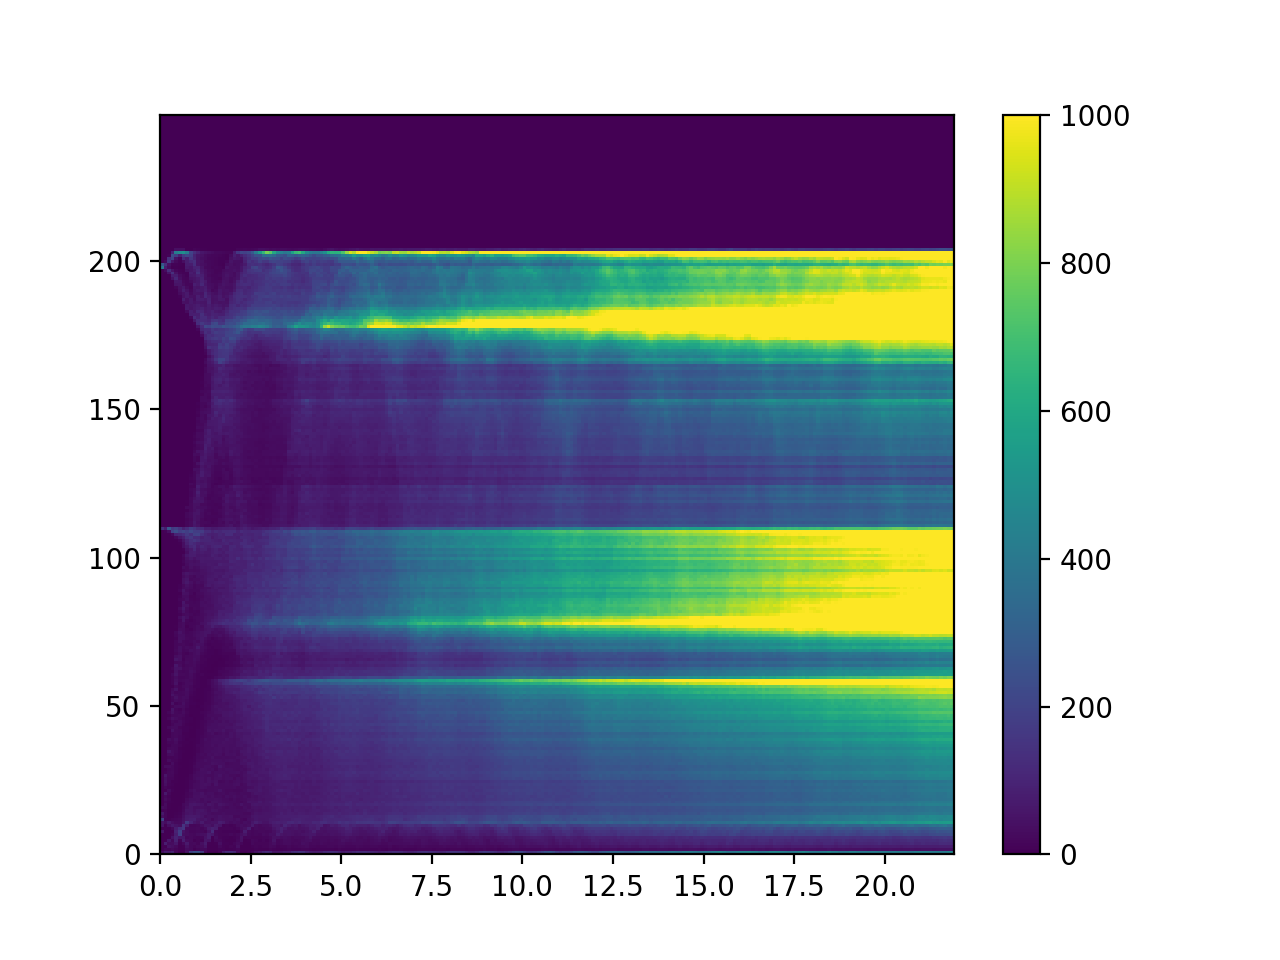

In [51]:
H.plot(IQEhist, max=1e3)